Epoch 1/15 - Train Acc: 0.4002, Val Acc: 0.6417
Epoch 2/15 - Train Acc: 0.5961, Val Acc: 0.7386
Epoch 3/15 - Train Acc: 0.6608, Val Acc: 0.7919
Epoch 4/15 - Train Acc: 0.6990, Val Acc: 0.7958
Epoch 5/15 - Train Acc: 0.7302, Val Acc: 0.8171
Epoch 6/15 - Train Acc: 0.7577, Val Acc: 0.8578
Epoch 7/15 - Train Acc: 0.7710, Val Acc: 0.8922
Epoch 8/15 - Train Acc: 0.7901, Val Acc: 0.8672
Epoch 9/15 - Train Acc: 0.7997, Val Acc: 0.8898
Epoch 10/15 - Train Acc: 0.8085, Val Acc: 0.8951
Epoch 11/15 - Train Acc: 0.8171, Val Acc: 0.8576
Epoch 12/15 - Train Acc: 0.8267, Val Acc: 0.9043
Epoch 13/15 - Train Acc: 0.8387, Val Acc: 0.8946
Epoch 14/15 - Train Acc: 0.8446, Val Acc: 0.9227
Epoch 15/15 - Train Acc: 0.8478, Val Acc: 0.9019


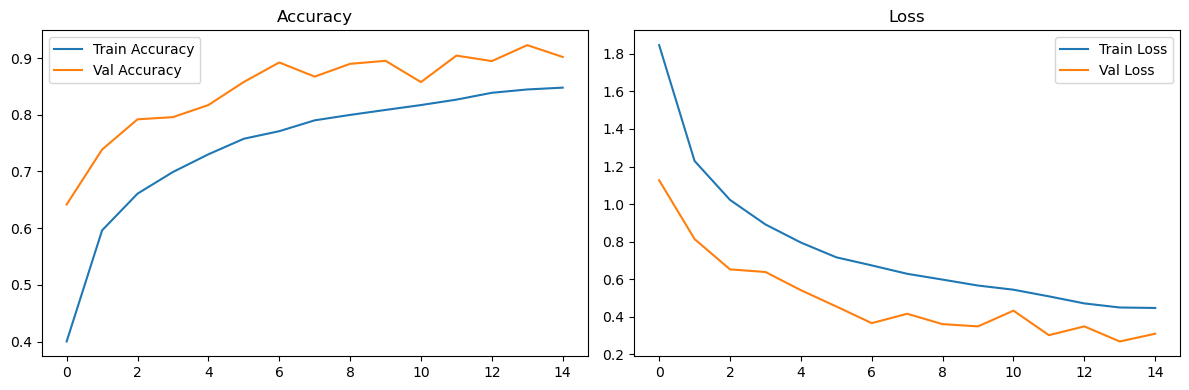

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.92      0.89      0.90       201
                     Pepper__bell___healthy       0.97      0.96      0.96       304
                      Potato___Early_blight       0.94      0.91      0.92       216
                       Potato___Late_blight       0.73      0.94      0.82       202
                           Potato___healthy       0.79      0.85      0.81        26
                      Tomato_Bacterial_spot       0.92      0.99      0.95       445
                        Tomato_Early_blight       0.89      0.49      0.64       178
                         Tomato_Late_blight       0.85      0.89      0.87       411
                           Tomato_Leaf_Mold       0.95      0.80      0.87       177
                  Tomato_Septoria_leaf_spot       0.86      0.90      0.88       343
Tomato_Spider_mites_Two_spotted_spider_mite       0.88      0.92

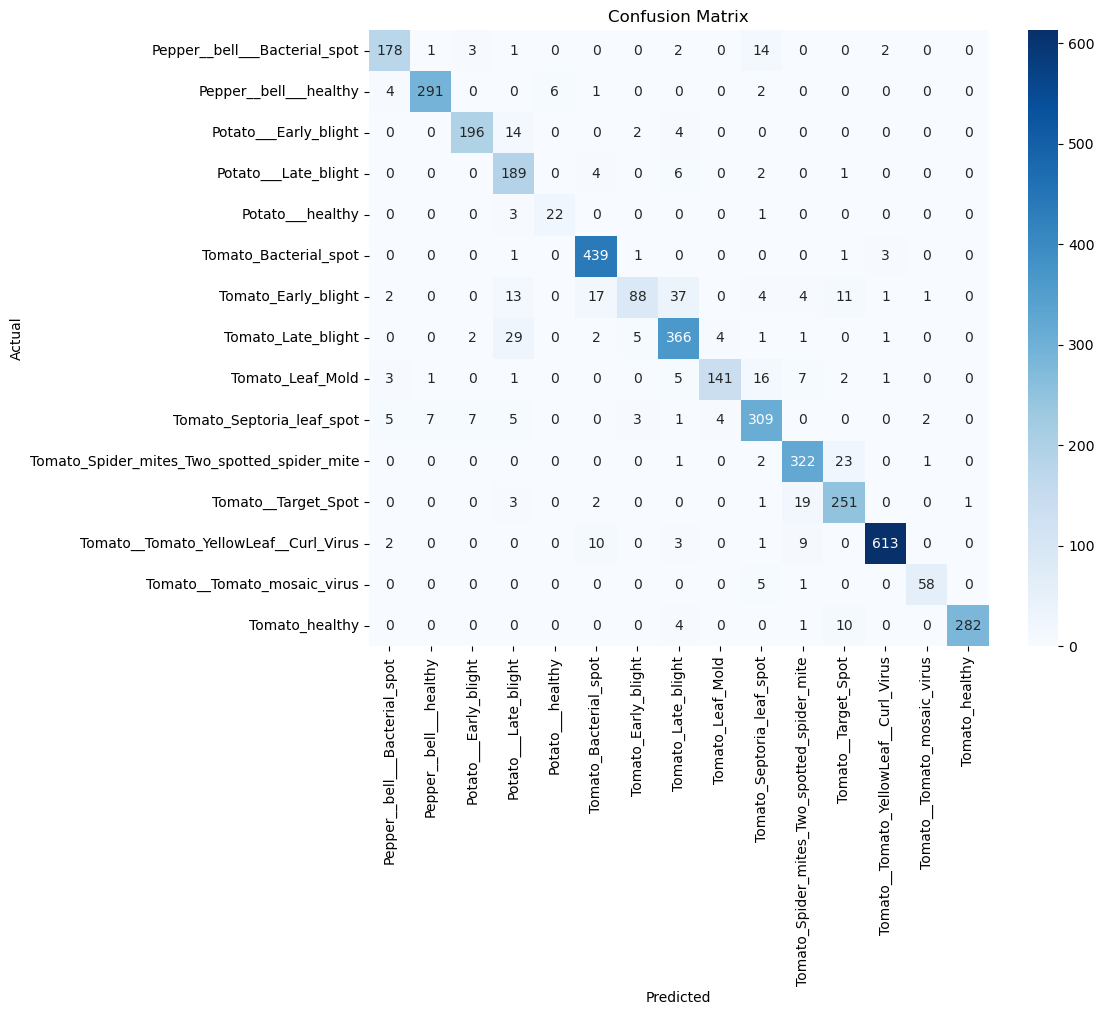

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Dataset path
data_dir = "C://Users//zayan//Downloads//ann//PlantVillage"

# Constants
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 32
EPOCHS = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
])

# Load data
train_data = datasets.ImageFolder(os.path.join(data_dir), transform=transform)
num_classes = len(train_data.classes)

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# CNN Model
class PlantDiseaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(PlantDiseaseCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 128), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)

model = PlantDiseaseCNN(num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
train_acc, val_acc, train_loss, val_loss = [], [], [], []
for epoch in range(EPOCHS):
    model.train()
    running_loss, correct = 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    train_acc.append(correct / len(train_loader.dataset))
    train_loss.append(running_loss / len(train_loader))

    model.eval()
    running_loss, correct = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
    val_acc.append(correct / len(val_loader.dataset))
    val_loss.append(running_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

# Save model
torch.save(model.state_dict(), "plant_disease_cnn_model.pth")

# Plot metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Val Accuracy")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Classification Report
print(classification_report(all_labels, all_preds, target_names=train_data.classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_data.classes, yticklabels=train_data.classes, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
